In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import requests
import pandas as pd
import time


2025-02-10 22:11:34.900162: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 22:11:34.900654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 22:11:34.903097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 22:11:34.913291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739221894.929059  345797 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739221894.93

In [ ]:
# Timestamps pour les 5 dernieres années
end_time = int(time.time())
start_time = end_time - (5 * 365 * 24 * 60 * 60)  

url = f"https://query1.finance.yahoo.com/v8/finance/chart/BTC-EUR?interval=1d&period1={start_time}&period2={end_time}"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()

    timestamps = data["chart"]["result"][0]["timestamp"]
    open = data["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = data["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = data["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = data["chart"]["result"][0]["indicators"]["quote"][0]["close"]

    df = pd.DataFrame({"date": timestamps, "open": open, "high": high, "low": low, "close": close})
    df["date"] = pd.to_datetime(df["date"], unit="s") 

    df.to_csv("bitcoin_historical_from_2020_to_now.csv", index=False)

    print(df.head())  

else:
    print(f"Erreur {response.status_code}: Impossible de récupérer les données")
    print(response.text)


        date         open         high          low        close
0 2020-02-13  9493.387695  9616.425781  9319.048828  9421.151367
1 2020-02-14  9418.541992  9523.971680  9341.442383  9521.362305
2 2020-02-15  9522.969727  9548.245117  9116.950195  9130.796875
3 2020-02-16  9130.571289  9282.718750  8976.573242  9163.173828
4 2020-02-17  9165.135742  9170.962891  8772.707031  8941.850586


In [17]:
# Chargement des données
data = pd.read_csv("bitcoin_historical_from_2020_to_now.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [18]:
# Prétraitement des données
features = data.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])
        y.append(data[i + sequence_length, -1])
    return np.array(X), np.array(y)

sequence_length = 120
X, y = create_sequences(scaled_data, sequence_length)


/home/rolyster/Documents/ESIR3/equipe1/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


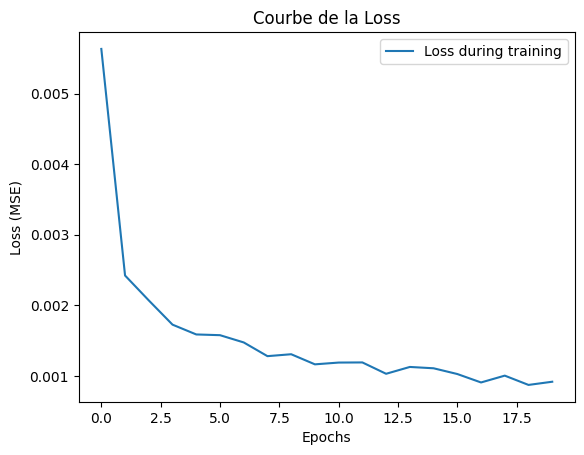

Erreur Quadratique Moyenne (MSE) sur l'ensemble de test: 7125843.458398336


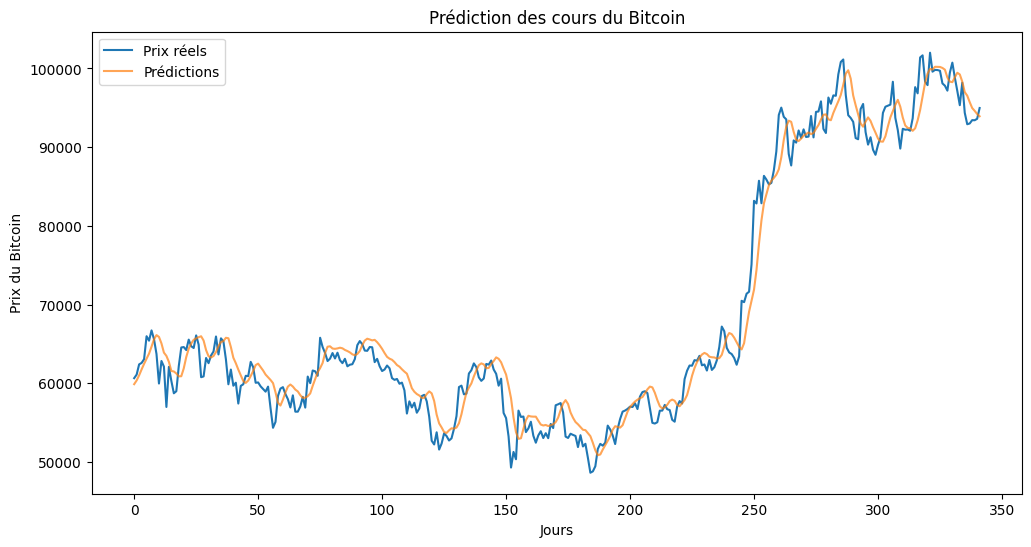

In [19]:
# Division des ensembles d'entraînement et de test (80% entraînement, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class GRUModel(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, dropout=0.2, optimizer='adam', batch_size=32, epochs=10):
        self.units = units
        self.dropout = dropout
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.history = None 

    def build_model(self):
        model = Sequential([
            GRU(self.units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            Dropout(self.dropout),
            GRU(self.units, return_sequences=False),
            Dropout(self.dropout),
            Dense(1)
        ])
        model.compile(optimizer=self.optimizer, loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.history = self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0)


best_params = {
    'batch_size': 32,
    'dropout': 0.3,
    'epochs': 20,
    'optimizer': 'rmsprop',
    'units': 50
}

# Entraînement du modèle
best_model = GRUModel(
    units=best_params['units'],
    dropout=best_params['dropout'],
    optimizer=best_params['optimizer'],
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs']
)

best_model.fit(X_train, y_train)

# Courbe de la perte pendant l'entraînement
plt.plot(best_model.history.history['loss'], label='Loss during training')
plt.title('Courbe de la Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Prédiction sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Pour inverser la normalisation, on reconstruit un tableau à 5 colonnes :
# Les 4 premières colonnes proviennent du dernier pas de temps de la séquence d'entrée
# La 5ème colonne est la valeur cible (Volume) (y ou y_pred)
# IMPORTANT : On utilise X_test[:, -1, :] et non X_test[:, -1, :-1] afin d'obtenir les 4 features d'origine.
X_test_last_feature = X_test[:, -1, :]  # Shape attendue : (n_samples, 4)

# Concaténation avec y_test pour obtenir un tableau (n_samples, 5)
y_test_with_features = np.concatenate([X_test_last_feature, y_test.reshape(-1, 1)], axis=1)

# Inversion de la normalisation pour récupérer les valeurs réelles du Volume
y_test_inv = scaler.inverse_transform(y_test_with_features)[:, -1]

# Idem pour les prédictions
y_pred_with_features = np.concatenate([X_test_last_feature, y_pred.reshape(-1, 1)], axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_with_features)[:, -1]

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Erreur Quadratique Moyenne (MSE) sur l'ensemble de test: {mse}")

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Prix réels')
plt.plot(y_pred_inv, label='Prédictions', alpha=0.7)
plt.title('Prédiction des cours du Bitcoin')
plt.xlabel('Jours')
plt.ylabel('Prix du Bitcoin')
plt.legend()
plt.show()

In [9]:
# Prédiction pour le lendemain

# On crée la dernière séquence à partir des dernières 60 observations.
# Ici, on prend les features d'entrée (toutes les colonnes sauf la cible, c'est-à-dire la dernière colonne).
last_sequence = scaled_data[-sequence_length:, :-1]  # shape: (60, n_features)
last_sequence = np.expand_dims(last_sequence, axis=0)   # reshape en (1, sequence_length, n_features)

# Prédiction à l'échelle normalisée
next_day_scaled = best_model.predict(last_sequence)  

# Pour inverser la normalisation, on reconstruit une ligne de données
# qui respecte le format d'origine utilisé lors de l'ajustement du scaler.
# On récupère le dernier jeu de features de la séquence (correspondant aux autres colonnes)
# et on y concatène la valeur prédite.
last_features = last_sequence[0, -1, :]              # shape: (n_features,)
next_day_row = np.concatenate([last_features, next_day_scaled[0]])  # shape: (n_columns,)
next_day_row = next_day_row.reshape(1, -1)

# Inversion de la normalisation pour obtenir la prédiction dans l'échelle d'origine.
next_day_price = scaler.inverse_transform(next_day_row)[0, -1]

print(f"Le cours prédit pour demain est : {next_day_price}")


Le cours prédit pour demain est : 97148.46407945336


Shape de X_test[:, -1, :] (342, 3)
Nombre de features disponibles : 3


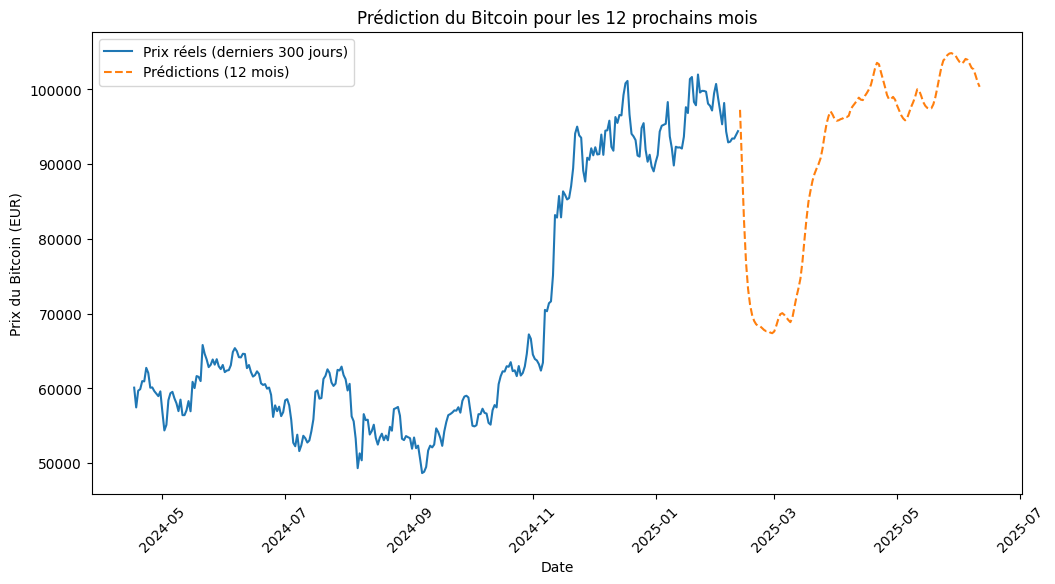

In [10]:

# Nombre de jours à prédire (12 mois)
future_days = 120

# Dernière séquence connue
last_sequence = X_test[-1]  # Dernière séquence de 60 jours

# Liste pour stocker les futures prédictions
future_predictions = []

# Génération de la prédiction jour par jour
for _ in range(future_days):
    # Prédire la prochaine valeur
    next_pred = best_model.predict(np.expand_dims(last_sequence, axis=0))[0][0]

    # Ajouter la prédiction à la liste
    future_predictions.append(next_pred)

    # Mise à jour de la séquence
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1, -1] = next_pred


# Récupération des valeurs moyennes des features disponibles
last_known_features = np.mean(X_test[:, -1, :], axis=0)  # Prendre toutes les features

# Vérification du nombre de colonnes
print(f"Nombre de features disponibles : {last_known_features.shape[0]}")

# Création d'un tableau avec les features + 1 target (prix prédiction)
future_predictions_with_features = np.column_stack([
    np.tile(last_known_features, (future_days, 1)),  # Répéter les features disponibles
    np.array(future_predictions).reshape(-1, 1)  # Valeur cible prédite
])

# Inversion de la normalisation
future_predictions_real = scaler.inverse_transform(future_predictions_with_features)[:, -1]

# Générer les dates pour la prédiction
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=future_days + 1)[1:]

# Tracé des prédictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[-300:], data['close'].values[-300:], label="Prix réels (derniers 300 jours)")
plt.plot(future_dates, future_predictions_real, label="Prédictions (12 mois)", linestyle="dashed")
plt.title("Prédiction du Bitcoin pour les 12 prochains mois")
plt.xlabel("Date")
plt.ylabel("Prix du Bitcoin (EUR)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [14]:
# Définition des paramètres
initial_balance = 10.0  
balance = initial_balance
bitcoin_held = 0  
transaction_history = [] 

# Simulation sur la période de test
for i in range(len(y_pred_inv) - 1):
    predicted_price_today = y_pred_inv[i]  
    predicted_price_tomorrow = y_pred_inv[i + 1] 
    real_price_today = y_test_inv[i]  
    real_price_tomorrow = y_test_inv[i + 1]  

    # Décision d'achat
    if predicted_price_tomorrow > predicted_price_today and balance > 0:
        bitcoin_held = balance / real_price_today  # Acheter BTC avec tout l'argent
        balance = 0  # Plus d'argent liquide
        transaction_history.append(("BUY", real_price_today, bitcoin_held))

    # Décision de vente
    elif predicted_price_tomorrow < predicted_price_today and bitcoin_held > 0:
        balance = bitcoin_held * real_price_today  # Vendre tous les BTC
        bitcoin_held = 0  # Plus de BTC en portefeuille
        transaction_history.append(("SELL", real_price_today, balance))

# Valeur finale du portefeuille (si on détient encore des BTC)
if bitcoin_held > 0:
    balance = bitcoin_held * y_test_inv[-1]

# Affichage des résultats
print(f"Balance initiale : {initial_balance}€")
print(f"Balance finale : {balance:.2f}€")
print(f"Performance totale : {((balance / initial_balance) - 1) * 100:.2f}%")

# Affichage des transactions
df_transactions = pd.DataFrame(transaction_history, columns=["Type", "Prix BTC", "Valeur"])
print("\nHistorique des transactions :")
print(df_transactions)


Balance initiale : 10.0€
Balance finale : 12.76€
Performance totale : 27.56%

Historique des transactions :
    Type       Prix BTC     Valeur
0    BUY   58772.386719   0.000170
1   SELL   63730.011719  10.843530
2    BUY   64555.195312   0.000168
3   SELL   60778.117187  10.209083
4    BUY   63535.992187   0.000161
..   ...            ...        ...
57  SELL  101996.046875  13.201926
58   BUY   99589.351563   0.000133
59  SELL   99794.859375  13.229169
60   BUY  100736.093750   0.000131
61  SELL   97130.132812  12.755616

[62 rows x 3 columns]
